In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
print(np.__version__)

1.26.4


## 1. 프로젝트 : Data Labeling

1. Price Change Direction 적용하기
2. Using Moving Average 적용하기
3. Local Min-Max 적용하기
4. Trend Scanning 적용하기

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

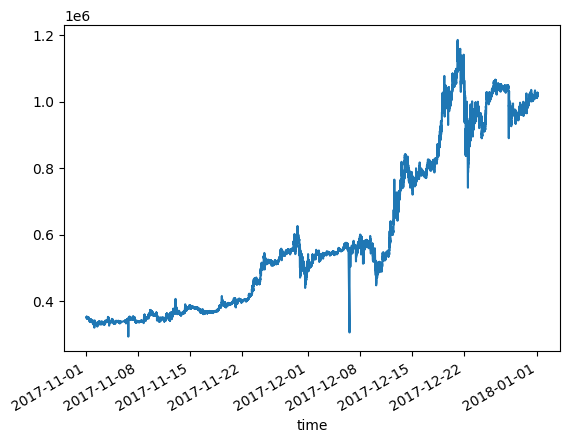

In [3]:
# 데이터 경로
DATA_PATH = '/content/drive/MyDrive/시계열_플젝'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

### 1-1. Price Change Direction 적용하기

In [7]:
# window 지정
window = 10 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

- 기존의 데이터(modify_data)에서 필요한 close(종가)를 가져오고,
- 수식이 적용된 데이터(s_momentum_signal)의 종가와 얼마나 차이가 있는지 확인하기 위해 데이터를 변환하고 시각화함.






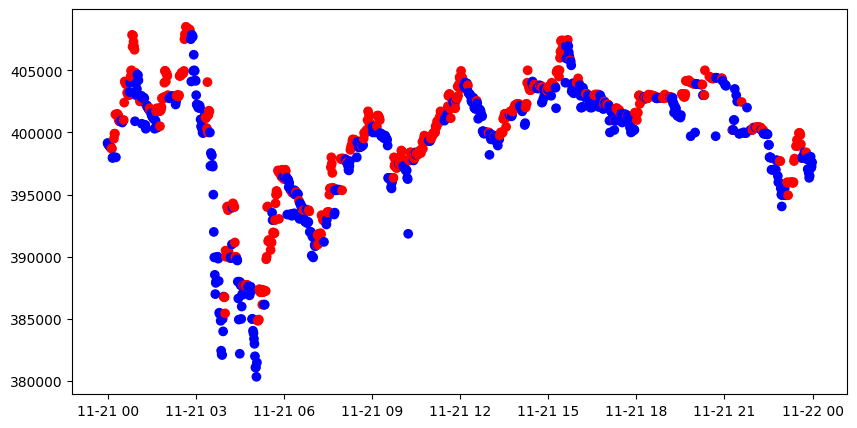

In [8]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### 1-2. Using Moving Average 적용하기


In [9]:
# momentum_signal
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

- Using Moving Average 수식을 적용한 것과 비교하기 위해 데이터를 변환하여 시각화를 통해 확인

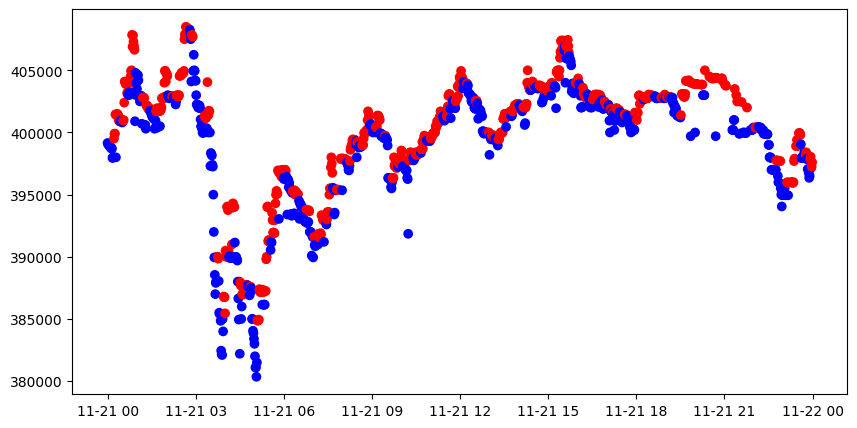

In [10]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### 1-3. Local Min-Max 적용하기

In [15]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [16]:
# Local mins, maxes를 확인
# return 값은 dict 형태로 2개의 df이 반환되어야함.
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인
# print(mins)
# print('--'*20)
# print(maxes)

(376546.5, 412585.0)

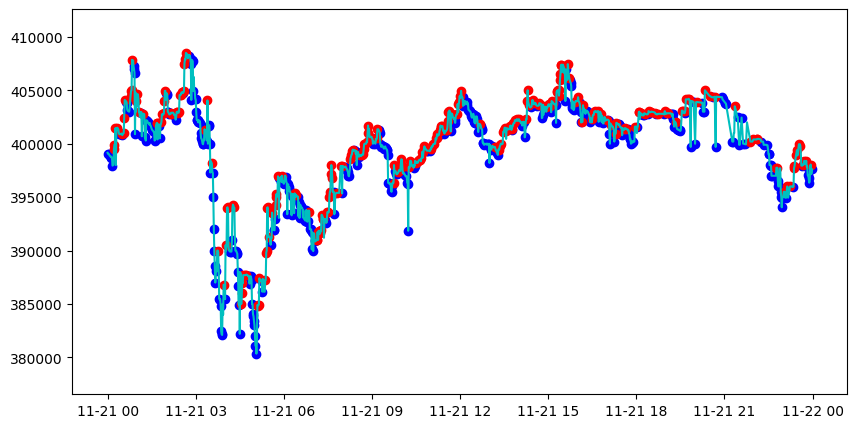

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

### 1-4. Trend Scanning 적용하기

- OLS는 회귀분석을 하는 경우 유용하게 사용 가능
- 아래 함수에서 ols.tvalue를 통해 t-value값을 사용할 수 있는 함수를 활용하여 추세(trend) 추정

In [20]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [21]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [22]:
# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [15:40<00:00, 35.49it/s]


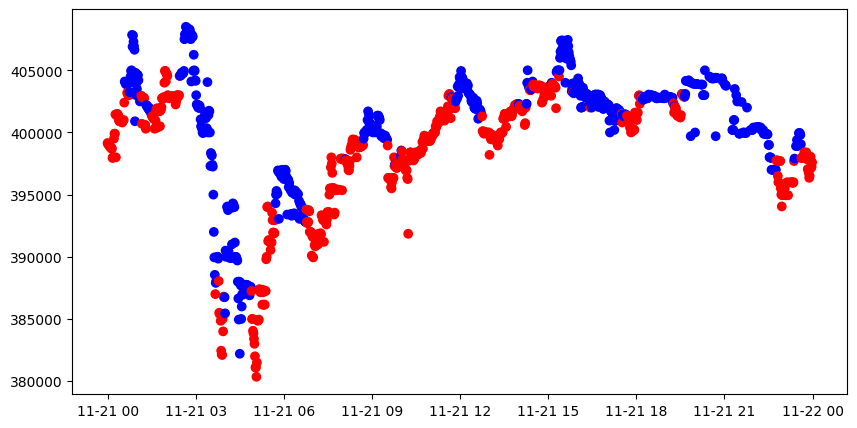

In [23]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

## 2. 프로젝트 : Feature Engineering

1. 환경구성 및 데이터 불러오기
2. Technical Index 적용하기
3. Feature Selection methods 적용하기

### 2-1. 환경구성 및 데이터 불러오기

In [24]:
!pip install ta==0.9.0
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28893 sha256=2cd2c1ffe211f9fac8916dd956a5dcd8e0fbd7b7e4f9ecf92013dad1ebb6b7c5
  Stored in directory: /root/.cache/pip/wheels/b5/fd/8d/250a0fe7de9a6bfc9c22235b544c550f9a868b9af79aa7e9ed
Successfully built ta


In [25]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/content/drive/MyDrive/시계열_플젝/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [26]:
# 데이터 경로 설정
DATA_PATH = '/content/drive/MyDrive/시계열_플젝'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

### 2-2. Technical Index 적용하기



In [27]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [28]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [29]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1]
y = df_tmp_data.iloc[:, -1]

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [30]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

### 2-3. Feature Selection methods 적용하기

#### 2-3-1. MDI, Mean Decrease Impurity

In [31]:
# MDI, Mean Decrease Impurity
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.043787,0.002349
volume_fi,0.044301,0.002318
volume_mfi,0.045600,0.002549
volume_sma_em,0.037433,0.002167
volume_vpt,0.025454,0.001777
volatility_atr,0.072630,0.003307
volatility_ui,0.051758,0.002301
trend_macd_diff,0.081183,0.004211
trend_adx,0.051755,0.002191
trend_trix,0.062752,0.003157


#### 2-3-2. MDA, Mean Decrease Accuracy

In [32]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [33]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

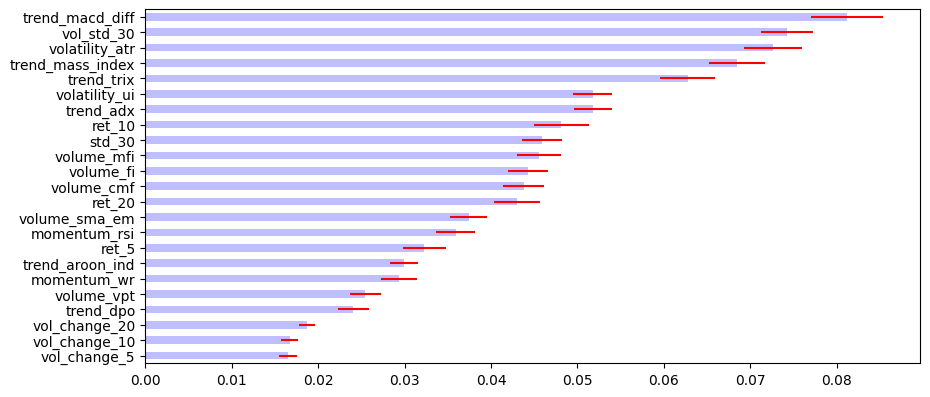

In [34]:
plot_feature_importance(feat_imp)

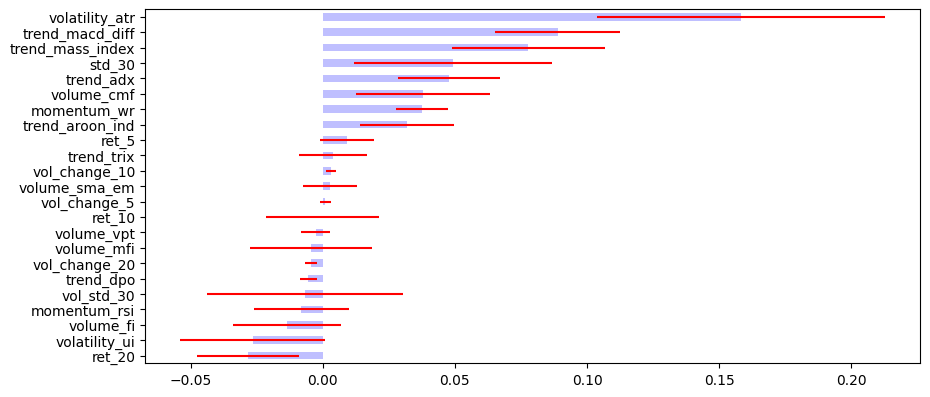

In [35]:
plot_feature_importance(feat_imp_mda)

### 2-4. Sequential Feature Selection

#### 2-4-1. RFE CV, Recursive Feature Elimination

In [36]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [37]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [94]:
selected_features = rfe_df[rfe_df["Optimal_Features"] == True].index.tolist()

#### 2-4-2. SFS, Sequential Feature Selection

In [38]:
n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [39]:
sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

#### 2-4-3. SHAP, Shapley Additive explanations

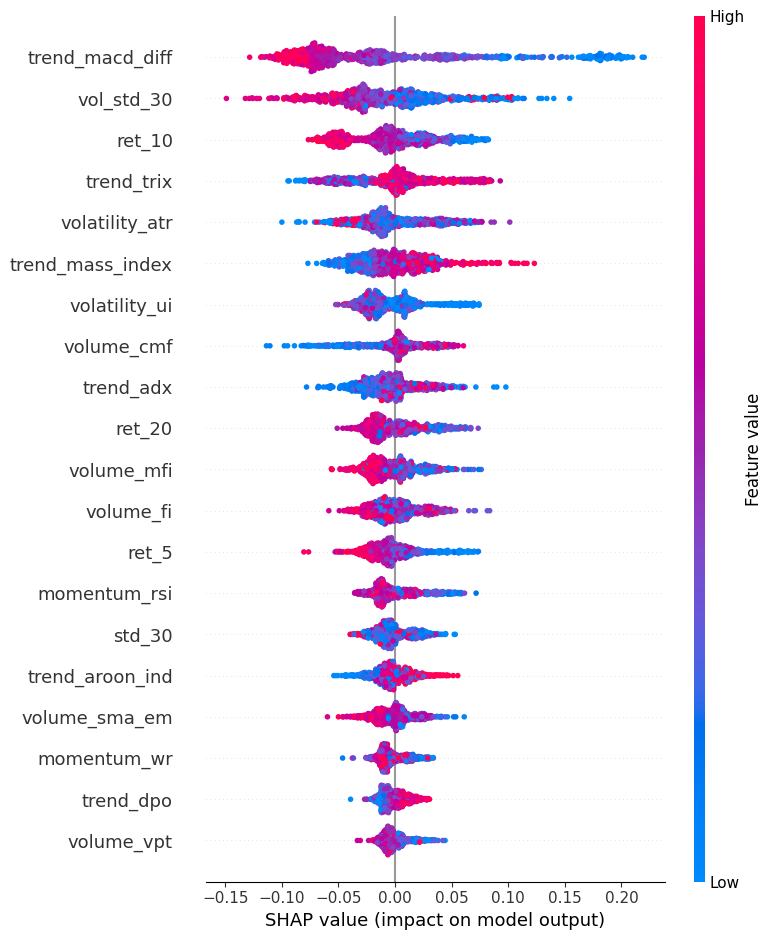

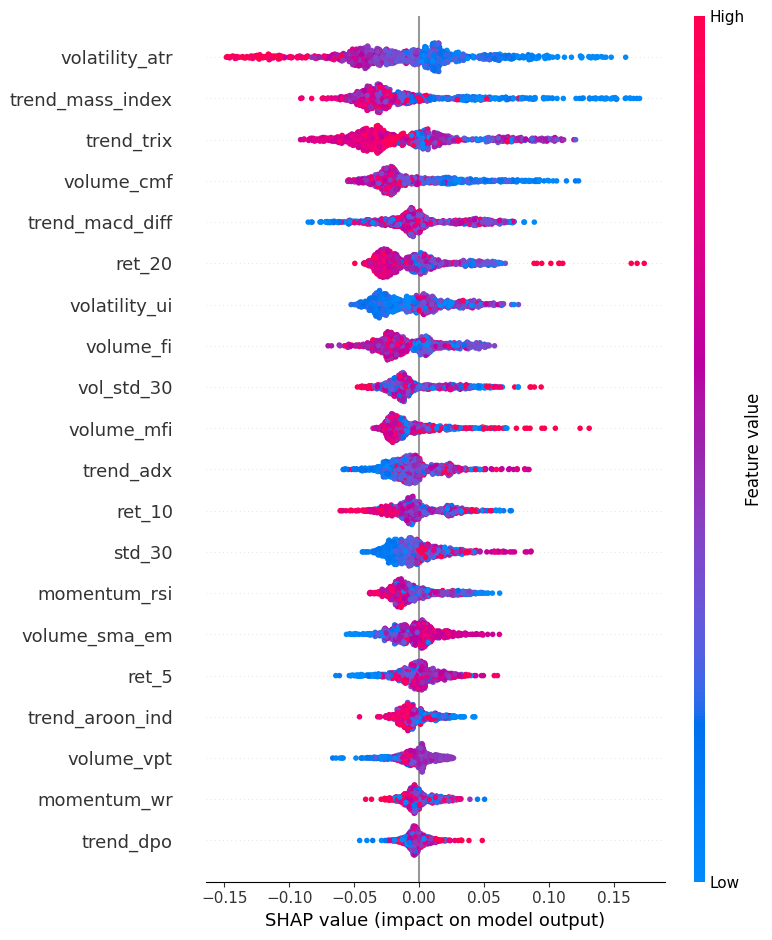

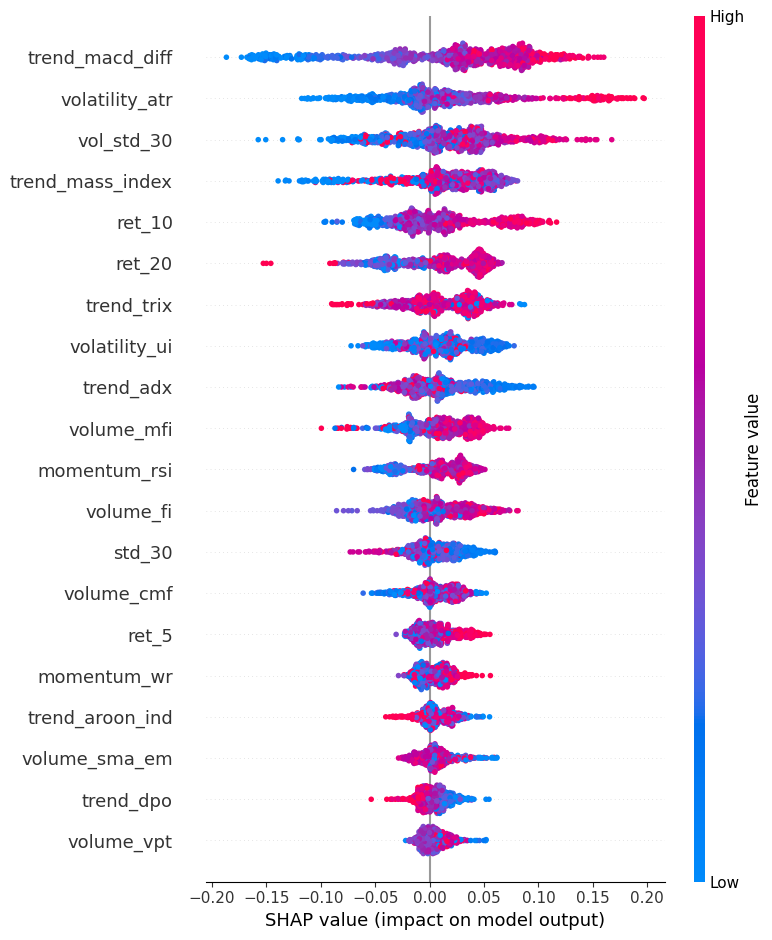

In [40]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc, model_output="raw")
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
# 클래스 0에 대한 SHAP summary plot
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

## 3. 프로젝트 : Model Traning

1. 환경구성 및 데이터 불러오기
2. Purged K-fold for Cross-Validation적용하기
3. Model 적용하기



### 3-1. 환경구성 및 데이터 불러오기

In [41]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/content/drive/MyDrive/시계열_플젝/')
from libs.mlutil.pkfold import PKFold

In [44]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/content/drive/MyDrive/시계열_플젝/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

### 3-2. Purged K-fold for Cross-Validation 적용하기

In [45]:
n_cv = 4 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

### 3-3. Model 적용하기

#### 3-3-1. LGBM + Bagging + SMOTE + GridSearchCV

In [83]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

smote = SMOTE(random_state=42)
train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)

lgbm = LGBMClassifier(class_weight='balanced', random_state=42)

bag_lgbm = BaggingClassifier(
    estimator=lgbm,
    n_jobs=-1,
    random_state=42
)

bc_params = {
    'n_estimators': [5, 10],  # 배깅에서 모델 수
    'max_features': [1.0],  # 배깅에서 특성 비율
    'bootstrap_features': [False],  # 특성 부트스트랩 off

    'estimator__n_estimators': [100, 300],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__max_depth': [5, -1],
    'estimator__num_leaves': [31, 63],
    'estimator__min_child_samples': [20]
}

gs_lgbm = GridSearchCV(
    estimator=bag_lgbm,
    param_grid=bc_params,
    cv=4,
    n_jobs=-1,
    verbose=1
)
gs_lgbm.fit(train_x_resampled, train_y_resampled)

gs_lgbm_best = gs_lgbm.best_estimator_

Fitting 4 folds for each of 32 candidates, totalling 128 fits


================= confusion matrix ====================
[[62 74]
 [13 42]]
정확도:0.5445026178010471, 정밀도:0.3620689655172414, 재현율:0.7636363636363637
auc:0.6919786096256685


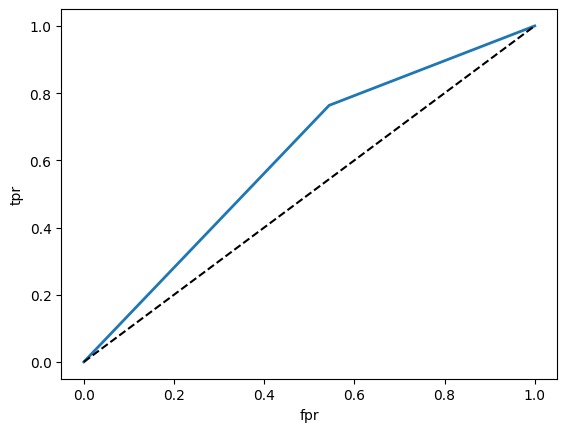

In [86]:
# 예측값 확인
pred_y = gs_lgbm_best.predict(test_x)
prob_y = gs_lgbm_best.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

#### 3-3-2. LGBM + SMOTE + GridSearchCV

In [ ]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

smote = SMOTE(random_state=42)
train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)

param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, -1],
    'num_leaves': [31, 63],
    'min_child_samples': [20],
}

gs_lgbm = GridSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gs_lgbm.fit(train_x_resampled, train_y_resampled)
lgbm_best = gs_lgbm.best_estimator_

================= confusion matrix ====================
[[59 77]
 [11 44]]
정확도:0.5392670157068062, 정밀도:0.36363636363636365, 재현율:0.8
auc:0.7276737967914438


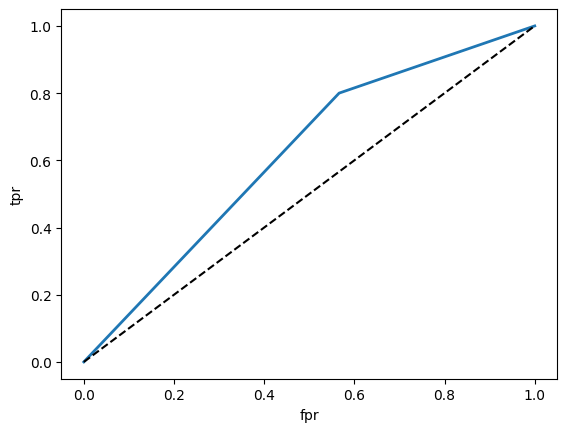

In [91]:
# 예측값 확인
pred_y = lgbm_best.predict(test_x)
prob_y = lgbm_best.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

#### 3-3-3. RFE CV + LGBM + SMOTE + GridSearchCV

In [95]:
# 1. RFE 결과에서 선택된 피처 목록 추출
selected_features = rfe_df[rfe_df["Optimal_Features"] == True].index.tolist()

# 2. 원본 데이터에서 선택된 피처만 추출
X = df_data[selected_features]
y = df_data['t_value']

# 3. standardization
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 4. 데이터 분할
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

train_x = X_sc[:n_train, :]
test_x = X_sc[-n_test:, :]
train_y = y.iloc[:n_train]
test_y = y.iloc[-n_test:]

# 5. DataFrame으로 변환 (피처 이름과 인덱스 유지)
train_x = pd.DataFrame(train_x, index=train_y.index, columns=selected_features)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=selected_features)

# 6. 학습 시간 단축용: 1000개만 사용
train_x = train_x[:1000]
train_y = train_y[:1000]


In [ ]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

smote = SMOTE(random_state=42)
train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)

param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, -1],
    'num_leaves': [31, 63],
    'min_child_samples': [20],
}

gs_lgbm = GridSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gs_lgbm.fit(train_x_resampled, train_y_resampled)
lgbm_best = gs_lgbm.best_estimator_

================= confusion matrix ====================
[[81 55]
 [12 43]]
정확도:0.6492146596858639, 정밀도:0.4387755102040816, 재현율:0.7818181818181819
auc:0.7937834224598931


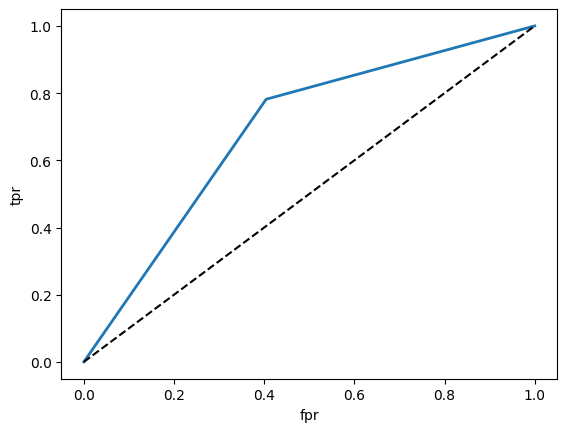

In [97]:
# 예측값 확인
pred_y = lgbm_best.predict(test_x)
prob_y = lgbm_best.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

#### 3-3-3. RFE CV + LGBM + SMOTE + optuna

In [99]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    scores = cross_val_score(model, train_x_resampled, train_y_resampled, cv=4, scoring='roc_auc')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # 빠르게 확인하려면 n_trials 줄이기

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

# 최적 모델로 학습
best_lgbm = LGBMClassifier(**study.best_params)
best_lgbm.fit(train_x_resampled, train_y_resampled)

================= confusion matrix ====================
[[81 55]
 [12 43]]
정확도:0.6492146596858639, 정밀도:0.4387755102040816, 재현율:0.7818181818181819
auc:0.7847593582887701


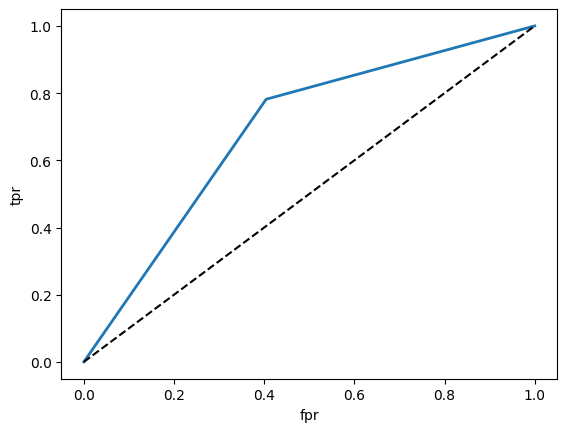

In [104]:
# 예측값 확인
pred_y = best_lgbm.predict(test_x)
prob_y = best_lgbm.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### 3-4. 모델 성능 비교 및 최종 모델 선정

### 🔍 성능 비교표

| 모델 조합                              | 정확도 (Accuracy) | 정밀도 (Precision) | 재현율 (Recall) | AUC               |
|---------------------------------------|-------------------|--------------------|------------------|-------------------|
| LGBM + Bagging + SMOTE + GridSearchCV | 0.5445            | 0.3621             | 0.7636           | 0.6920            |
| LGBM + SMOTE + GridSearchCV           | 0.5393            | 0.3636             | 0.8000           | 0.7277            |
| RFE CV + LGBM + SMOTE + GridSearchCV  | **0.6492**        | **0.4388**         | **0.7818**       | **0.7938**        |
| RFE CV + LGBM + SMOTE + Optuna        | **0.6492**        | **0.4388**         | **0.7818**       | 0.7848            |

---

✅ 최종 모델 선정 기준

- `AUC`가 0.79 이상으로 가장 높은 조합은 `RFE CV + LGBM + SMOTE + GridSearchCV`.
- Optuna 기반 모델은 AUC는 약간 낮지만, 동일한 정량 지표(정확도/정밀도/재현율)를 보임.
- 하지만 **GridSearchCV 모델이 AUC 기준에서 가장 우수**하므로 **최종 모델로 선정**함.

---

### 🏆 최종 선정 모델

**RFE CV + LGBM + SMOTE + GridSearchCV**

해당 모델은 피처 선택을 통해 불필요한 변수를 제거하고, SMOTE로 클래스 불균형을 해결했으며, GridSearchCV를 통해 하이퍼파라미터를 최적화함으로써 가장 우수한 성능을 보였다.
